Below mentioned code is written with the assumption that we are having 2 directories namely CATS and DOGS in the present directory. These directories has images of cats and dogs respectively. Directories are not uploaded to github because of large size.

However, images cab be downloaded from https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765



In [1]:
import os
import cv2
import numpy as np
import tqdm as tqdm
import torch
from tqdm import tqdm as tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:


REBUILD_DATA = False

path = '/content/drive/MyDrive/Cat an Dog/kagglecatsanddogs_3367a/PetImages/'
class DogsVSCats():
    IMG_SIZE = 224
    cats = path+"Cat"
    dogs = path+"Dog"
    LABELS = {cats: 0, dogs: 1}
    
    training_data = []
    
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                
                    path = os.path.join(label,f)
                    
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.cats:
                        self.catcount+=1
                    elif label == self.dogs:
                        self.dogcount+=1
                except Exception as e:
                    pass
            
        np.random.shuffle(self.training_data)
        np.save("training_data_bw.npy",self.training_data)
        print("cats: "+str(self.catcount))
        print("dogs: "+str(self.dogcount))
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

# Visualizing Data

In [4]:
import os
import cv2
import numpy as np
import tqdm as tqdm
import torch

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='cuda', index=0)

In [7]:
import numpy as np
training_data = np.load('/content/drive/MyDrive/training_data_bw.npy', allow_pickle=True)

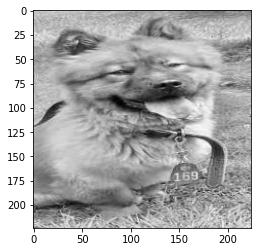

In [8]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0], cmap="gray")

# Building Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [10]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [12]:
model = model.to(device)

In [13]:
model(torch.reshape(torch.tensor(training_data[0][0],dtype=torch.float32),(-1,1,224,224)).to(device)).shape

torch.Size([1, 1000])

In [14]:


net = nn.Sequential(  nn.BatchNorm2d(1),
                      model,
                      nn.Dropout(0.6),
                      nn.Linear(1000, 2)
                      ).to(device)


# Training the Model

In [15]:
batch_size = 200
epochs = 4

In [16]:

from tqdm import tqdm as tqdm

optimizer = torch.optim.Adam(net.parameters(), lr=0.00001,weight_decay = 1e-5)  
train_size = int(batch_size*0.8)

for _ in range(epochs):
  train_count = 0
  train_cum_loss = 0

  val_count = 0
  val_cum_loss = 0
  X=[]
  Y=[]
  
  for i in tqdm(range(len(training_data))):

      x = torch.reshape(torch.tensor(training_data[i][0],dtype=torch.float32).to(device),(-1,1,224,224))
      X.append(x)
      y = torch.tensor([training_data[i][1]],dtype=torch.float32).to(device)
      Y.append(y)
      if i%batch_size == 0 and i != 0:
        net.train()
        X = torch.cat(X,dim=0)
        X=X.view(-1,1,224,224)
        Y = torch.cat(Y,dim=0)
        

        X_train = X[:train_size]
        Y_train = Y[:train_size]

        X_val = X[train_size:]
        Y_val = Y[train_size:]

        
        output = net(X_train)
        loss = F.binary_cross_entropy_with_logits(output, Y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_cum_loss+=loss.item()
        train_count+=1

        net.eval()
        output_eval = net(X_val)
        loss_eval = F.binary_cross_entropy_with_logits(output_eval, Y_val)

        val_count += 1
        val_cum_loss += loss_eval.item()
        X=[]
        Y=[]
        
  print('train loss',train_cum_loss/train_count ,'val loss',val_cum_loss/val_count)



100%|██████████| 25016/25016 [00:36<00:00, 679.53it/s]


train loss 0.676375292301178 val loss 0.544403708934784


100%|██████████| 25016/25016 [00:36<00:00, 689.34it/s]


train loss 0.38659236788749696 val loss 0.31085452675819397


100%|██████████| 25016/25016 [00:36<00:00, 690.09it/s]


train loss 0.27773381209373477 val loss 0.2489266905784607


100%|██████████| 25016/25016 [00:36<00:00, 690.56it/s]

train loss 0.20744906276464462 val loss 0.22198903876543044


In [17]:
torch.save(net.state_dict(),f"catNdog.pth")